In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns

all_states = pd.read_csv('data/4.18states.csv');
abridge = pd.read_csv('data/abridged_couties.csv');
#import all data set and tools

In [2]:
states = all_states[all_states['Country_Region'] == 'US'];
# I want to use just 48 states. (without Hawai, Alaska)
list_states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"];
states = states[states['Province_State'].isin(list_states) == True];
states = states.rename(columns = {'Province_State' : 'State'});
states = states.drop([1, 15]);
states = states.reset_index(drop = True);

In [3]:
# I want to use not only the number of confirmed people, but also population.
pop_states = abridge.groupby(['State', 'StateName'])['PopulationEstimate2018'].sum();
pop_states = pop_states.to_frame().reset_index();
pop_states = pop_states.drop([7]);
pop_states = pop_states.rename(columns = {'PopulationEstimate2018' : 'Pop'});
pop_states = pop_states.reset_index(drop = True);
pop_con = pop_states.merge(states[['State', 'Lat', 'Long_', 'Confirmed']], on = 'State');
pop_con = pop_con.sort_values('Confirmed', ascending = False);

In [4]:
# I will select three cities that have the high number of confirmed people, and get longitude and latitude of those.
list_cities = ['New York', 'Florida', 'California'];
lat1 = pop_con[pop_con['State'] == list_cities[0]]['Lat'];
long1 = pop_con[pop_con['State'] == list_cities[0]]['Long_'];
lat2 = pop_con[pop_con['State'] == list_cities[1]]['Lat'];
long2 = pop_con[pop_con['State'] == list_cities[1]]['Long_'];
lat3 = pop_con[pop_con['State'] == list_cities[2]]['Lat'];
long3 = pop_con[pop_con['State'] == list_cities[2]]['Long_'];
con1 = pop_con[pop_con['State'] == list_cities[0]]['Confirmed'];
con2 = pop_con[pop_con['State'] == list_cities[1]]['Confirmed'];
con3 = pop_con[pop_con['State'] == list_cities[2]]['Confirmed'];
pop_con['Lat_1st'] = pop_con['Lat'] - float(lat1);
pop_con['Lat_2nd'] = pop_con['Lat'] - float(lat2);
pop_con['Lat_3rd'] = pop_con['Lat'] - float(lat3);
pop_con['Long_1st'] = pop_con['Long_'] - float(long1);
pop_con['Long_2nd'] = pop_con['Long_'] - float(long2);
pop_con['Long_3rd'] = pop_con['Long_'] - float(long3);

In [5]:
# new data frame for predicting model.
X_variables = pd.DataFrame({
    'population': pop_con['Pop'],
    'Lat1': pop_con['Lat_1st'] * float(con1),
    'Lat2': pop_con['Lat_2nd'] * float(con2),
    'Lat3': pop_con['Lat_3rd'] * float(con3),
    'Long1': pop_con['Long_1st'] * float(con1),
    'Long2': pop_con['Long_2nd'] * float(con2),
    'Long3': pop_con['Long_3rd'] * float(con3)
});
Y_confirmed = pd.DataFrame(pop_con['Confirmed']);

In [6]:
#this is the first test, and it doesn't seem to work well. (not good RSME)
linear_model = lm.LinearRegression()
linear_model.fit(X_variables[:30], Y_confirmed[:30]);
Y_fitted = linear_model.predict(X_variables);
np.sqrt(np.mean((Y_confirmed - Y_fitted)**2))

Confirmed    30988.543335
dtype: float64

In [7]:
#To get distances from three states
pop_con['distance1'] = (111 * pop_con['Lat_1st']) * (111 * pop_con['Lat_1st']) + (83 * pop_con['Long_1st']) * (83 * pop_con['Long_1st']);
pop_con['distance1'] = np.sqrt(pop_con['distance1']);
pop_con['distance2'] = (111 * pop_con['Lat_2nd']) * (111 * pop_con['Lat_2nd']) + (99 * pop_con['Long_2nd']) * (99 * pop_con['Long_2nd']);
pop_con['distance2'] = np.sqrt(pop_con['distance2']);
pop_con['distance3'] = (111 * pop_con['Lat_3rd']) * (111 * pop_con['Lat_3rd']) + (90 * pop_con['Long_3rd']) * (90 * pop_con['Long_3rd']);
pop_con['distance3'] = np.sqrt(pop_con['distance3']);

Text(0.5, 0, 'Distance from Each City')

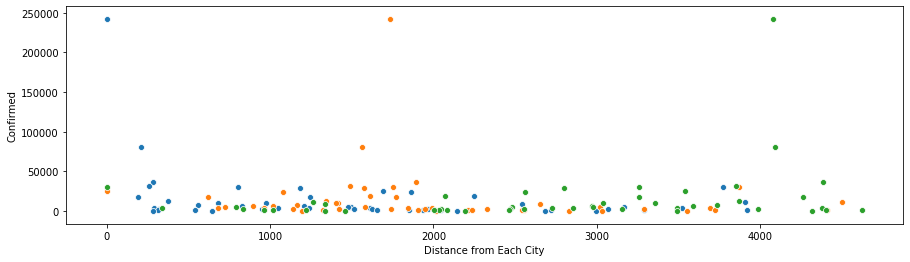

In [8]:
#According to distance, I assumed there would be similar 'Confirmed' values.
plt.figure(figsize=(15,4))
sns.scatterplot(pop_con['distance1'], pop_con['Confirmed']);
sns.scatterplot(pop_con['distance2'], pop_con['Confirmed']);
sns.scatterplot(pop_con['distance3'], pop_con['Confirmed']);
plt.xlabel('Distance from Each City')

In [9]:
# Function for getting mean value of three closest states
def mean_three_near_cities(data, i) :
    """input : data (data frame)
        i = ith city (0 ~ 47)
        
        output : sum of confirmed of near three cities 
    """
    lat_i = data[data.index == i]['Lat'];
    long_i = data[data.index == i]['Long_'];
    #Use a certain distance for 1 degree of long and lat
    data['distance_i'] = np.sqrt((111 * (pop_con['Lat'] - float(lat_i))) * (111 * (pop_con['Lat'] - float(lat_i))) + (90 * (pop_con['Long_'] - float(long_i))) * (90 * (pop_con['Long_'] - float(long_i))));
    data = data.sort_values('distance_i').reset_index();
    data = data.loc[1:3];
    value = data['Confirmed'].sum();
    return value/3;

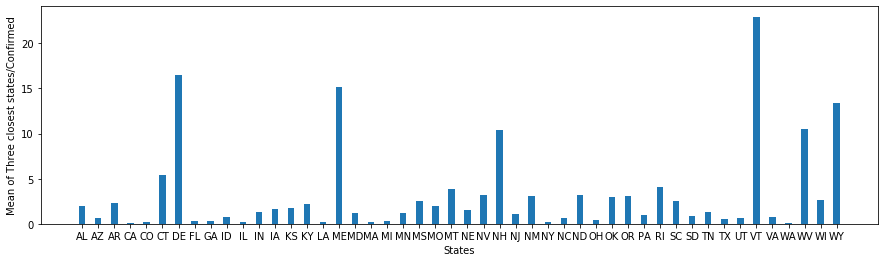

In [10]:
#Graph to show mean value of three closest states and 'Confirmed' value of one city.
pop_con = pop_con.sort_values('State').reset_index(drop = True);
list_mean = [mean_three_near_cities(pop_con, i) for i in range(len(pop_con.index))];
plt.figure(figsize=(15,4))
pop_con['mean_three'] = list_mean;
plt.bar(pop_con['StateName'], pop_con['mean_three']/pop_con['Confirmed'],  width=0.4)
plt.xlabel('States');
plt.ylabel('Mean of Three closest states/Confirmed');

In [11]:
#I think some cities that have a very large number of confirmed people make predictions hard.
#pop_con.sort_values('Confirmed', ascending = False)
#I will drop some states (New York and New Jersey). This will not make perfect model even if the predict is very reliable

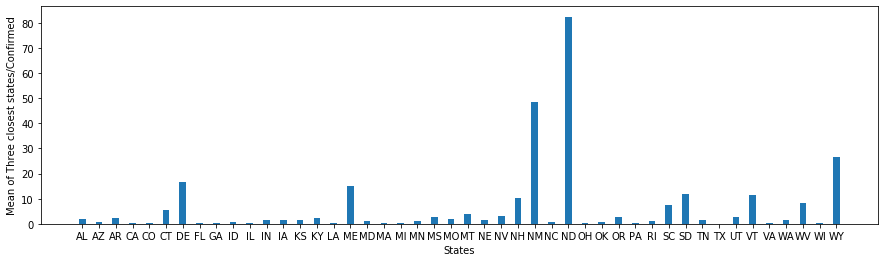

In [12]:
#Similar graph without New York and New Jersey.
plt.figure(figsize=(15,4))
new_pop_con = pop_con.drop([29,27]).reset_index(drop = True);
new_pop_con['mean_three'] = [mean_three_near_cities(pop_con, i) for i in range(len(new_pop_con.index))];
plt.bar(new_pop_con['StateName'], new_pop_con['mean_three']/new_pop_con['Confirmed'],  width=0.4)
plt.xlabel('States');
plt.ylabel('Mean of Three closest states/Confirmed');

In [13]:
# Function to make variables for predicting model. 
def mk_variables(data, i) :
    """input : data (data frame)
        i = ith city (0 ~ 47)
        
        output : sum of confirmed of near three cities 
    """
    lat_i = data[data.index == i]['Lat'];
    long_i = data[data.index == i]['Long_'];
    #Use a certain distance for 1 degree of long and lat
    data['distance_i'] = np.sqrt((111 * (pop_con['Lat'] - float(lat_i))) * (111 * (pop_con['Lat'] - float(lat_i))) + (90 * (pop_con['Long_'] - float(long_i))) * (90 * (pop_con['Long_'] - float(long_i))));
    data = data.sort_values('distance_i').reset_index();
    pop = data.loc[0]['Pop']
    data = data.loc[1:3];
    return np.array(data['Confirmed']);

X_variables1 = [mk_variables(new_pop_con, i) for i in range(len(new_pop_con.index))];
Y_confirmed1 = np.array(new_pop_con['Confirmed']);

In [14]:
#rmse is better than before
linear_model1 = lm.LinearRegression()
linear_model1.fit(X_variables1[:30], Y_confirmed1[:30]);
Y_predicted = linear_model1.predict(X_variables1);
np.sqrt(np.mean((Y_confirmed1 - Y_predicted)**2))

10302.814812141829

In [15]:
#But predicted value is not close to real value.
Y_predicted - Y_confirmed1

array([  5059.36979847,   6126.09986558,   7351.9337786 , -18969.51895248,
         2026.13756696, -10203.28414581,   8121.97841137, -16725.06925881,
        -6245.16147187,  10272.35962519, -18638.48300979,  -3211.50676352,
         7065.02579798,   5898.21831153,   8691.26044548, -11315.23188498,
         7286.83460952,    170.56021908, -25955.61034645, -21889.27018436,
         7718.54389358,   4774.5725301 ,   2013.61453218,  11450.23857943,
         8809.86333686,   2666.4121071 ,   3900.87659276,   8659.46596989,
         5996.94007638,   9092.82997003,   1463.14147492,  10589.13919246,
        10493.38314682, -20885.82342803,   -910.92194097,   4497.08298984,
        11336.54796105,   4212.5803338 , -15243.11723035,   9024.18852275,
         4985.7697499 ,   2295.31128577,    804.33150369,  11571.96712244,
         1382.64256471,  11662.29990692])